Decrement Table

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


l0 = 1000 # Initital pool of policyholders
age = 35  # Age of policyholder used for single cell
premium = 500 # Yearly premium
claims = 500000 # Fixed annuity in case of death


# Loading data from reference tables
vbt_table = pd.read_excel("VBT_2015.xlsx", skiprows=23, nrows=79)

df_vbt = pd.DataFrame(vbt_table)
df_vbt_singlecell = df_vbt[df_vbt[r"Row\Column"] == age]
df_vbt_singlecell = df_vbt_singlecell.drop(columns=[r"Row\Column"]).iloc[:, 0:20]


#  Creating lapse rate dataframe using study data
lapse_rate = [0.1, 0.08] # For year 1 and 2
for n in range(3, 21):
  lapse_rate.append(0.05) # For year 3 through 20

df_lapse = pd.DataFrame([lapse_rate])


# Combining Mortality and Lapse Rate DataFrames and renaming index column
df_lapse.columns = df_vbt_singlecell.columns

df_combined = pd.concat([
    df_vbt_singlecell.reset_index(drop=True),
    df_lapse.reset_index(drop=True)
    ], axis=0)

df_combined.index = ["Mortality Rate", "Lapse Rate"]


# Calculating Survival Rate and Survivors

# Total lives lost due to Mortality and Lapses
df_combined.loc["Net Retention"] = (1 - df_combined.loc["Mortality Rate"]) * (1 - df_combined.loc["Lapse Rate"])
df_combined.loc["End Lives"] = l0 * df_combined.loc["Net Retention"].cumprod()

# Population at start of year
start_lives = [l0] + df_combined.loc["End Lives"].iloc[:-1].tolist()
df_combined.loc["Start Lives"] = start_lives

# Death count due to Mortality and Survivors without lapses
df_combined.loc["Death Count"] = df_combined.loc["Start Lives"] * df_combined.loc["Mortality Rate"]
df_combined.loc["Mid-Year Survivors"] = df_combined.loc["Start Lives"] - df_combined.loc["Death Count"]

# Lapse count each year
df_combined.loc["Lapse Count"] = df_combined.loc["Mid-Year Survivors"] * df_combined.loc["Lapse Rate"]

# print(f"{df_combined}\n")

Cash Flow Projection


Total PV Premiums:   $4,207,806.15
Total PV Expenses:   $520,780.62
Total PV Claims:     $2,517,958.39
Net Present Value:   $1,169,067.15
Profit Margin:       27.78%


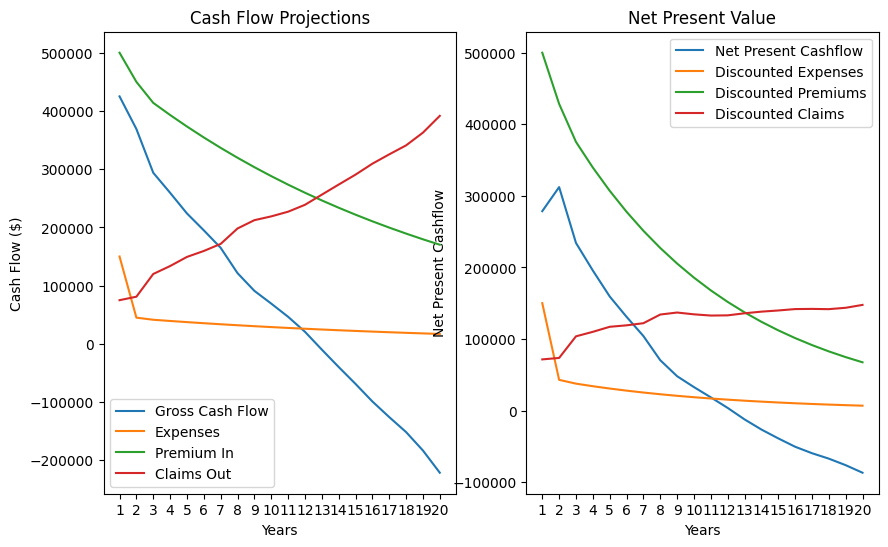

In [5]:
# Cash Flow Projections

df_cashflow = df_combined.loc[["Start Lives", "Death Count"]].copy().T
df_cashflow.index.name = "Year"

df_cashflow = df_cashflow.apply(pd.to_numeric, errors="coerce")

df_cashflow["Premium In"] = df_cashflow["Start Lives"] * premium
df_cashflow["Claims Out"] = df_cashflow["Death Count"] * claims
df_cashflow["Gross Cash Flow"] = df_cashflow["Premium In"] - df_cashflow["Claims Out"]

cum_cf = df_cashflow["Gross Cash Flow"].cumsum()


expense_commission = 150 # Fixed expense and commission per year per policyholder
expense_maintenance = 50 # Fixed maintenance cost per year per policyholder

df_cashflow.loc["1", "Expenses & Commissions"] = df_cashflow.loc["1", "Start Lives"] * expense_commission
df_cashflow.loc["2":, "Expenses & Commissions"] = df_cashflow.loc["2":,"Start Lives"] * expense_maintenance


# Discounting Cashflow
# Base assumptions
interest_rate = 0.05
discount_rate = 1 / (1 + interest_rate)

# Discount Rate for Year Start and End
df_cashflow["Discount Factor Start"] = discount_rate ** (df_cashflow.index.astype(int) - 1)
df_cashflow["Discount Factor End"] = discount_rate ** df_cashflow.index.astype(int)

# Discounted present value of Premiums, Claims and Expenses
df_cashflow["Discounted Premium In"] = df_cashflow["Discount Factor Start"] * df_cashflow["Premium In"]
df_cashflow["Discounted Claims Out"] = df_cashflow["Discount Factor End"] * df_cashflow["Claims Out"]
df_cashflow["Discounted Expenses"] = df_cashflow["Discount Factor Start"] * df_cashflow["Expenses & Commissions"]

df_cashflow["Net Present Cashflow"] = df_cashflow["Discounted Premium In"] - df_cashflow["Discounted Claims Out"] - df_cashflow["Discounted Expenses"]


# Aggregated Present Value of all components
total_pv_premiums = df_cashflow["Discounted Premium In"].sum()
total_pv_claims = df_cashflow["Discounted Claims Out"].sum()
total_pv_expenses = df_cashflow["Discounted Expenses"].sum()

npv = total_pv_premiums - total_pv_claims - total_pv_expenses

#print(df_cashflow.head())

# Output statement of all relevant present values

print("\n" + "="*40)
print(f"Total PV Premiums:   ${total_pv_premiums:,.2f}")
print(f"Total PV Expenses:   ${total_pv_expenses:,.2f}")
print(f"Total PV Claims:     ${total_pv_claims:,.2f}")
print(f"Net Present Value:   ${npv:,.2f}")
print("="*40)


# Profit margin basic calculation
profit_margin = npv / total_pv_premiums
print(f"Profit Margin:       {profit_margin:.2%}")


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.lineplot(x=df_cashflow.index, y=df_cashflow["Gross Cash Flow"], label="Gross Cash Flow", ax=ax[0])
sns.lineplot(x=df_cashflow.index, y=df_cashflow["Expenses & Commissions"], label="Expenses", ax=ax[0])
sns.lineplot(x=df_cashflow.index, y=df_cashflow["Premium In"], label="Premium In", ax=ax[0])
sns.lineplot(x=df_cashflow.index, y=df_cashflow["Claims Out"], label="Claims Out", ax=ax[0])
ax[0].set_title("Cash Flow Projections")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Cash Flow ($)")
ax[0].legend()


sns.lineplot(x=df_cashflow.index, y=df_cashflow["Net Present Cashflow"], label="Net Present Cashflow", ax=ax[1])
sns.lineplot(x=df_cashflow.index, y=df_cashflow["Discounted Expenses"], label="Discounted Expenses", ax=ax[1])
sns.lineplot(x=df_cashflow.index, y=df_cashflow["Discounted Premium In"], label="Discounted Premiums", ax=ax[1])
sns.lineplot(x=df_cashflow.index, y=df_cashflow["Discounted Claims Out"], label="Discounted Claims", ax=ax[1])
ax[1].legend()
ax[1].set_title("Net Present Value")
ax[1].set_xlabel("Years")

plt.show()

Margin Optimizations

In [6]:
def calculate_financials(premium, df_combined, claims, interest_rate=0.05):

  df_cashflow = df_combined.loc[["Start Lives", "Death Count"]].copy().T
  df_cashflow.index.name = "Year"

  df_cashflow = df_cashflow.apply(pd.to_numeric, errors="coerce")

  df_cashflow["Premium In"] = df_cashflow["Start Lives"] * premium
  df_cashflow["Claims Out"] = df_cashflow["Death Count"] * claims
  df_cashflow["Gross Cash Flow"] = df_cashflow["Premium In"] - df_cashflow["Claims Out"]

  cum_cf = df_cashflow["Gross Cash Flow"].cumsum()

  expense_commission = 150 # Fixed expense and commission per year per policyholder
  expense_maintenance = 50 # Fixed maintenance cost per year per policyholder

  df_cashflow.loc["1", "Expenses & Commissions"] = df_cashflow.loc["1", "Start Lives"] * expense_commission
  df_cashflow.loc["2":, "Expenses & Commissions"] = df_cashflow.loc["2":,"Start Lives"] * expense_maintenance


  # Discounting Cashflow
  discount_rate = 1 / (1 + interest_rate)

  # Discount Rate for Year Start and End
  df_cashflow["Discount Factor Start"] = discount_rate ** (df_cashflow.index.astype(int) - 1)
  df_cashflow["Discount Factor End"] = discount_rate ** df_cashflow.index.astype(int)

  # Discounted present value of Premiums, Claims and Expenses
  df_cashflow["Discounted Premium In"] = df_cashflow["Discount Factor Start"] * df_cashflow["Premium In"]
  df_cashflow["Discounted Claims Out"] = df_cashflow["Discount Factor End"] * df_cashflow["Claims Out"]
  df_cashflow["Discounted Expenses"] = df_cashflow["Discount Factor Start"] * df_cashflow["Expenses & Commissions"]

  df_cashflow["Net Present Cashflow"] = df_cashflow["Discounted Premium In"] - df_cashflow["Discounted Claims Out"] - df_cashflow["Discounted Expenses"]

  # Aggregated Present Value of all components
  total_pv_premiums = df_cashflow["Discounted Premium In"].sum()
  total_pv_claims = df_cashflow["Discounted Claims Out"].sum()
  total_pv_expenses = df_cashflow["Discounted Expenses"].sum()
  npv = total_pv_premiums - total_pv_claims - total_pv_expenses

  # Profit margin basic calculation
  profit_margin = npv / total_pv_premiums if total_pv_premiums != 0 else 0

  return profit_margin, npv, total_pv_premiums


# Profit margin optimisation
# Start parameters
target_margin = 0.07
current_premium = 500
tolerance = 0.001
step_size = 1

margin, npv, pv_prems = calculate_financials(current_premium, df_combined, claims)

print(f"Before: Premium: ${current_premium:.2f}, Margin: {margin:.2%}, NPV: ${npv:,.2f}, PV Premiums: ${pv_prems:,.2f}")

# Loop through margin calculating function until target margin is reached
while abs(margin - target_margin) > tolerance:
  if margin < target_margin:
    current_premium += step_size
  else:
    current_premium -= step_size

  margin, npv, pv_prems = calculate_financials(current_premium, df_combined, claims)

print(f"After: Premium: ${current_premium:.2f}, Margin: {margin:.2%}, NPV: ${npv:,.2f}, PV Premiums: ${pv_prems:,.2f}")

Before: Premium: $500.00, Margin: 27.78%, NPV: $1,169,067.15, PV Premiums: $4,207,806.15
After: Premium: $388.00, Margin: 6.94%, NPV: $226,518.57, PV Premiums: $3,265,257.57
